 EDA on Airfares around Jakarta using Kaggle dataset
 
https://www.kaggle.com/datasets/datasciencerikiakbar/tiketcom-best-price-for-flights-from-jakarta?select=tiketcom_bestprice.csv



Importing necessary libraries

In [619]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm,kurtosis
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


## Dataset Preparation
1. Merge the distance between airports and the price datasets.
2. Handling the flights that are much later than those in the rest of the dataset

"Mudik" in Indonesia is a seasonal movement of people that causes an increase in flight ticket demand, resulting in higher prices. The objective here is to conduct a best price analysis of flight tickets during the mudik season with respect to factors such as distance, day of the week/month.

For the analysis, two datasets have been taken into consideration. The first dataset, which captures the distance between the airports in Indonesia, is referred to as the distance dataset. The second dataset consists of the best prices extracted from the ticket.com website at various timestamps. These two datasets are merged based on the origin and destination to create a consolidated dataset.

In [21]:
## Reading the distance and ticket price files and passing the separator as "|"
tick_price=pd.read_csv('./tiketcom_bestprice.csv',sep='|')
dist_airp=pd.read_csv('./distance_between_indonesian_airports.csv',sep="|")

In [22]:
print("Display the top rows of ticket price dataset")
print(tick_price.head(2))

print("Display the top rows of distance dataset")
print(dist_airp.head(2))

Display the top rows of ticket price dataset
            extract_timestamp origin destination depart_date  best_price
0  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-25   2310582.0
1  2022-12-24 11:25:37.656571   JKTC         BTJ  2023-04-04   2310582.0
Display the top rows of distance dataset
  airport_from airport_to  distance_km  flight_time_hour
0          CGK        BTJ      1797.98              2.65
1          CGK        BDO       133.25              1.10


In [23]:
# The data types of the columns of distance matrix are displayed below
dist_airp.dtypes


airport_from         object
airport_to           object
distance_km         float64
flight_time_hour    float64
dtype: object

In [24]:
# The data types of the columns of distance matrix are displayed below
tick_price.dtypes


extract_timestamp     object
origin                object
destination           object
depart_date           object
best_price           float64
dtype: object

In [25]:
print(tick_price["origin"].unique())
print(dist_airp["airport_from"].unique())
# The distance data has code CKG in unique values

['JKTC']
['CGK']


In [26]:
# A column named origin is added to the dataframe with the name JKTC to be used as a key while joining the dataframes
dist_airp["origin"]="JKTC"

In [27]:
dist_airp[['airport_from', 'airport_to']] = dist_airp[['airport_from', 'airport_to']].astype(str)

The "dtype" of string, dict, list is always object, for testing type need select some value of column

In [28]:
#
dist_airp.dtypes
print (type(dist_airp['airport_from'].iloc[0]))
#print (dist_airp['airport_from'].apply(type))

<class 'str'>


Change the data type of the date column in the tick_price using  to_datetime function

In [29]:

tick_price['depart_date'] = pd.to_datetime(tick_price['depart_date'], format='%Y-%m-%d')
tick_price.head(2)

,extract_timestamp,origin,destination,depart_date,best_price
0,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-25,2310582.0
1,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-04,2310582.0


Filtering the tick_price for a specific depart date and destination. For a specific depart date there are multiple records that correspond to the extraction performed at different timestamps.

In [177]:

tick_price[(tick_price['depart_date'] == '2023-04-25') & (tick_price['destination'] == 'MKQ')].head(2)


,extract_timestamp,origin,destination,depart_date,best_price
848,2022-12-24 11:25:37.656571,JKTC,MKQ,2023-04-25,4786080.0
1714,2022-12-25 08:06:32.241556,JKTC,MKQ,2023-04-25,4786080.0


In [73]:
ticket_price_dist=pd.merge(tick_price, dist_airp, left_on=['origin', 'destination'], right_on=['origin', 'airport_to'], how='inner')

In [74]:
print(ticket_price_dist.shape)
print(tick_price.shape)

(45438, 9)
(45438, 5)


Displaying the summary of the merged dataset below.

In [75]:
ticket_price_dist.describe(include="all")

C:\Users\vidya\AppData\Local\Temp\ipykernel_3440\2581949323.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ticket_price_dist.describe(include="all")


,extract_timestamp,origin,destination,depart_date,best_price,airport_from,airport_to,distance_km,flight_time_hour
count,45438,45438,45438,45438,4.543800e+04,45438,45438,45438.000000,45438.000000
unique,15,1,29,233,NaN,1,29,NaN,NaN
top,2022-12-29 03:13:11.798742,JKTC,JOG,2023-04-04 00:00:00,NaN,CGK,JOG,NaN,NaN
freq,5203,45438,1586,404,NaN,45438,1586,NaN,NaN
first,NaN,NaN,NaN,2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2024-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.491694e+06,NaN,NaN,1138.913832,2.079785
std,NaN,NaN,NaN,NaN,1.087001e+06,NaN,NaN,948.908693,1.060239
min,NaN,NaN,NaN,NaN,3.672000e+05,NaN,NaN,133.250000,1.100000
25%,NaN,NaN,NaN,NaN,7.894000e+05,NaN,NaN,478.420000,1.350000


After reviewing the summary, several observations can be made. Firstly, there is only one origin airport in Indonesia, which is either JKTC or CGK. Additionally, there are 29 unique destinations available from Jakarta. The data covers flight departures from January 1, 2023, through June 2024. Furthermore, there are multiple extracted best prices available for different origin-destination combinations. Lastly, the farthest places in Indonesia are located approximately 3774 km apart with a flying time of 5 hours.

The recurring departure date of April 4 falls within the month of Ramadan. To gain further insights, analysis on the day-to-day spread is conducted below.

The derived variables have been added to the dataframe below by extracting timestamps from the 'extract_time_stamp' column.

In [76]:
ticket_price_dist['extract_timestamp'] = pd.to_datetime(ticket_price_dist['extract_timestamp']) 

In [77]:
ticket_price_dist['extract_date'] =  pd.to_datetime(ticket_price_dist['extract_timestamp'].dt.date)
ticket_price_dist['time'] = ticket_price_dist['extract_timestamp'].dt.time
ticket_price_dist.head()

,extract_timestamp,origin,destination,depart_date,best_price,airport_from,airport_to,distance_km,flight_time_hour,extract_date,time
0,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-25,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571
1,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-04,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571
2,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-27,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571
3,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-29,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571
4,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-01,2316313.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571


Extracting weekday, calendar year, month and day from the departure dates column.

In [78]:
ticket_price_dist['weekday_name'] = ticket_price_dist['depart_date'].dt.day_name() 
ticket_price_dist['calendar_day'] = ticket_price_dist['depart_date'].dt.day
ticket_price_dist['calendar_year'] = ticket_price_dist['depart_date'].dt.year
ticket_price_dist['calendar_month'] = ticket_price_dist['depart_date'].dt.month
ticket_price_dist['week_number'] =ticket_price_dist['depart_date'].apply(lambda x: x.isocalendar()[1])

The data is available for both the years 2023 and 2024. The records corresponding to the year 2024 are filtered and analysed to check for the completeness 

In [79]:
check_yr=ticket_price_dist.loc[ticket_price_dist['calendar_year']==2024]
check_yr.groupby(['airport_to'])['depart_date'].nunique()

airport_to
BIK     1
BPN     2
DPS    12
JOG    11
KNO     1
LOP     2
SUB     1
UPG     1
YIA    12
Name: depart_date, dtype: int64

Out of the 29 unique destinations from Jakarta, only 9 have departure best price information available in the dataset, which contains 2024 flights. For airports such as YIA, JOG, and DPS, this information is available for only two or three dates in a month until August. For the remaining airports, the best price is available for only 1 or 2 days, and as a result, 2024 is not included in the analysis further.

In [80]:
ticket_price_dist=ticket_price_dist.loc[ticket_price_dist['calendar_year']==2023]
ticket_price_dist.shape

(45395, 16)

The column 'extraction_period' is defined as the difference between the depart date and date time during extraction

In [82]:
ticket_price_dist["extraction_period"]= ticket_price_dist["depart_date"] - ticket_price_dist['extract_date']
ticket_price_dist.head(2)

,extract_timestamp,origin,destination,depart_date,best_price,airport_from,airport_to,distance_km,flight_time_hour,extract_date,time,weekday_name,calendar_day,calendar_year,calendar_month,week_number,extraction_period
0,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-25,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571,Tuesday,25,2023,4,17,122 days
1,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-04,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571,Tuesday,4,2023,4,14,101 days


In [40]:
ticket_price_dist.to_csv('ticket_price_dist.csv')

In [83]:
ticket_price_dist.shape

(45395, 17)

##  Average Price Analysis by Sector and Distance range

To obtain a more comprehensive view of the dataset, the destinations are grouped based on the distance they cover. This enables the identification of patterns and trends that may not be evident when looking at individual destinations. To determine the distance ranges, the quantile function is utilized, which partitions the dataset into equal-sized groups. This approach provides a systematic and objective means of grouping destinations based on their distance.

To obtain the quantile values for the distance column in the dataframe, the 'quantile()' function, which calculates the specified quantile[0.25,0.5,0.75]s of the column values is used.

In [84]:
num_buckets = 4

# Creating a list to store the quantile values and append it to make required number of cuts
quantiles = []
for i in range(1, num_buckets):
     quantiles.append(i/num_buckets)
quantile_values = dist_airp['distance_km'].quantile(quantiles)

In [85]:
quantile_values

0.25     493.8800
0.50     882.2900
0.75    1371.1125
Name: distance_km, dtype: float64

To perform the analysis at a daily level, the flight origin and destination have been grouped based on the distance range they fall within. This was done by utilizing the quantile values extracted and following categories are defined for the purpose of analysis.

1. Short-haul flights: distances less than or equal to 400 km

2. Medium-haul flights: distances between 400 and 900 km

3. Long-haul flights: distances between 900 km and 1400 km

4. Ultra-long-haul flights: distances greater than 1400 km

Note: This is not a universal definition

In [141]:
ticket_price_dist['distance_km'].min()
[ticket_price_dist['distance_km'].min()] + list([500,900,1400]) + [ticket_price_dist['distance_km'].max()]

[133.25, 500, 900, 1400, 3773.77]

In [372]:
# Assigning labels according to the distance column
bucketized_values = pd.cut(ticket_price_dist['distance_km'], bins=[ticket_price_dist['distance_km'].min()-0.25] + list([400,900,1400]) + [ticket_price_dist['distance_km'].max()], labels=['short-haul', 'medium-haul', 'long-haul', 'ultra-long'])

# Adding the cut values as a new column in the dataframe
ticket_price_dist['sectors'] = bucketized_values


In [218]:
ticket_price_dist.groupby(['sectors'])['airport_to'].nunique()

sectors
short-haul      2
medium-haul    13
long-haul       7
ultra-long      7
Name: airport_to, dtype: int64

The number of destinations in the medium-haul range is higher compared to long and ultra-long-haul routes. For short-haul routes, there are only two airports, which is understandable.

In [88]:
## Unique values of the sectors column
ticket_price_dist['sectors'].unique()

['ultra-long', 'short-haul', 'medium-haul', 'long-haul']
Categories (4, object): ['short-haul' < 'medium-haul' < 'long-haul' < 'ultra-long']

__Plotting the average price change day by day from Jan till August of 2023__

Text(0.5, 1.0, 'Average Cost Across Different Airplane Sectors in Indonesia by day')

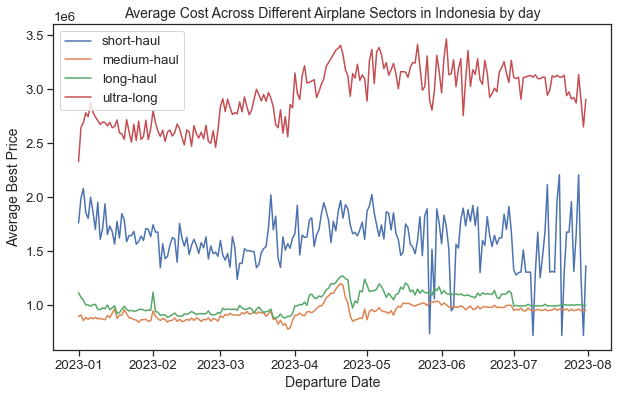

In [355]:

mean_price_date=ticket_price_dist.groupby(['depart_date', 'sectors']).agg({'best_price': 'mean'}).reset_index()

# Setting the style and size of the plot
sns.set(style='ticks', font_scale=1.2)

## Setting the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Passing the x and y values for the line plot
sns.lineplot(x='depart_date', y='best_price', hue='sectors', data=mean_price_date)

# Location is set to to upper left of the legend to not interfere with the graph
ax.legend(loc='upper left')

# Setting the x and y labels along with the graph titles
ax.set_ylabel('Average Best Price', fontsize=14)
ax.set_xlabel('Departure Date', fontsize=14)
ax.set_title('Average Cost Across Different Airplane Sectors in Indonesia by day', fontsize=14)


It is evident that there is a noticeable increase in ticket prices during the festival month in Indonesia. This season refers to the annual tradition of Indonesian Muslims returning to their hometowns to celebrate Eid with their families. In 2023, Ramadan is observed from March 22 to April 20, and during this period, there is a clear increase in demand across all three sectors, except for short haul flights. Therefore, further investigation is conducted into the months of March, April, and May.

When it comes to short-haul flights, the demand,service availability, and several other unknown factors that are not present in the data appear to be erratic, which drive the price pattern.

The information is rolled up at week level to smoothen the dataset and observe the patterns.

In [356]:
##Aggregating the data by weeks
mean_price_week=ticket_price_dist.groupby(['week_number', 'sectors']).agg({'best_price': 'mean'}).reset_index()


In [103]:
mean_price_week.head(2)

,week_number,sectors,best_price
0,1,short-haul,1.890608e+06
1,1,medium-haul,8.811244e+05


In [371]:
print(mean_price_week['week_number'].unique()) 

#There is a jump in the information after August hence the view is filtered for weeks below 52
mean_price_week=mean_price_week.loc[mean_price_week['week_number']<52,]  

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 52]


__Plot of the average best price rolled up at week level.__

Text(0.5, 1.0, 'Average Cost Across Different Airplane Sectors in Indonesia by Week')

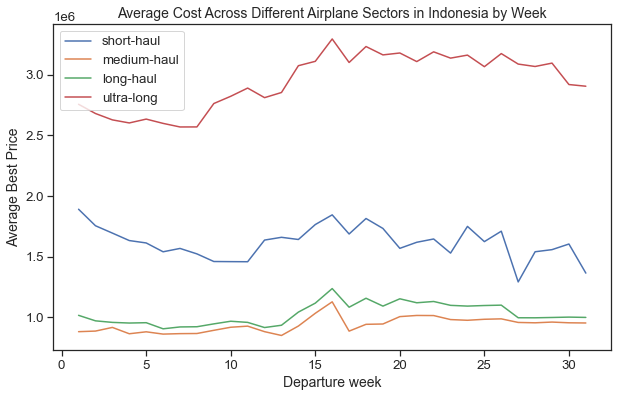

In [354]:
sns.set(style='ticks', font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='week_number', y='best_price', hue='sectors', data=mean_price_week)
ax.legend(loc='upper left')
ax.set_ylabel('Average Best Price', fontsize=14)
ax.set_xlabel('Departure week', fontsize=14)
ax.set_title('Average Cost Across Different Airplane Sectors in Indonesia by Week', fontsize=14)


Now zoom in to the particular weeks to focus on the time period that includes the festival and a few weeks before and after it

__Plot of the average best price along with the percentage change at the week level__

In [186]:

mean_price_week_1=ticket_price_dist.loc[(ticket_price_dist['depart_date'] > '2023-03-5') & (ticket_price_dist['depart_date'] < '2023-05-7')]
mean_price_week_1=mean_price_week_1.groupby(['week_number', 'sectors']).agg({'best_price': 'mean'}).reset_index()

In [187]:
mean_price_week_1.week_number.unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18], dtype=int64)

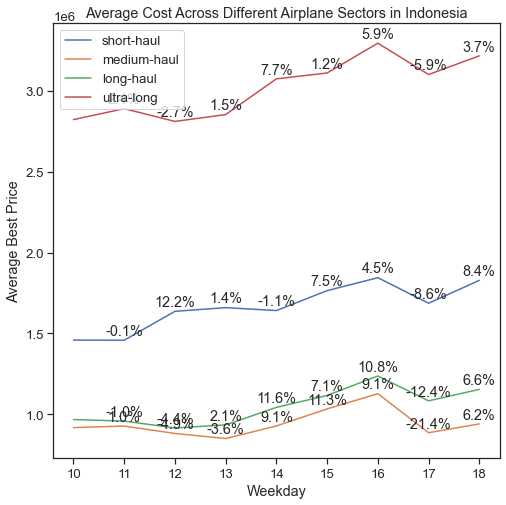

In [114]:
fig, ax = plt.subplots(figsize=(8, 8))

#Iterating through a for loop
for cat in ['short-haul', 'medium-haul', 'long-haul','ultra-long']:
    cat_data = mean_price_week_1[mean_price_week_1['sectors'] == cat]
    perc_changes = cat_data['best_price'].pct_change() * 100

    ax.plot(cat_data['week_number'], cat_data['best_price'], label=cat)
    # Adding the percentage change values as text on top of the line graph
    for i, val in enumerate(perc_changes[1:]):
        ax.annotate(f"{val:.1f}%", (cat_data.iloc[i+1]['week_number'], cat_data.iloc[i+1]['best_price']),
                    xytext=(0, 5), textcoords='offset points', ha='center')
ax.legend(loc='upper left')
ax.set_xlabel('Weekday')
ax.set_ylabel('Average Best Price')
ax.set_title('Average Cost Across Different Airplane Sectors in Indonesia')
plt.show()
    

The Mudik season usually starts in March, and the busiest travel period occurs around mid-April during the national holiday. An analysis of ticket prices for short-haul routes revealed a spike in the average price during the first week of the season (week 12), with a 12.2% increase likely caused by increased demand. Prices then stabilize in the following week before gradually rising as we go towards week 16. In contrast, the other three sectors display a steady increase in prices towards the last two weeks of the festival in mid-April.

In [376]:
mean_price_week_dest=ticket_price_dist#.loc[(ticket_price_dist['depart_date'] > '2023-03-5') & (ticket_price_dist['depart_date'] < '2023-05-7')]

mean_price_week_dest.head(2)

,extract_timestamp,origin,destination,depart_date,best_price,airport_from,airport_to,distance_km,flight_time_hour,extract_date,time,weekday_name,calendar_day,calendar_year,calendar_month,week_number,extraction_period,sectors,key
0,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-25,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571,Tuesday,25,2023,4,17,122 days,ultra-long,ultra-longBTJ
1,2022-12-24 11:25:37.656571,JKTC,BTJ,2023-04-04,2310582.0,CGK,BTJ,1797.98,2.65,2022-12-24,11:25:37.656571,Tuesday,4,2023,4,14,101 days,ultra-long,ultra-longBTJ


In [377]:
mean_price_week_dest["key"]=mean_price_week_dest['sectors'].astype(str) + mean_price_week_dest['airport_to']
mean_price_week_dest=mean_price_week_dest.groupby(['key','week_number']).agg({'best_price': 'mean'}).reset_index()

In [378]:
mean_price_week_dest.head(2)

,key,week_number,best_price
0,long-haulBDJ,1,1.172313e+06
1,long-haulBDJ,2,1.165241e+06


 __Plot the average airfare by distance between airports__

In [150]:

mean_price_dist_buck=ticket_price_dist.groupby(['sectors']).agg({'best_price': 'mean'})
mean_price_dist_buck=mean_price_dist_buck.reset_index()
#mean_price_date= mean_price_date.loc[mean_price_date['depart_date']<'2024-01-01',]


Text(0.5, 1.0, 'Average Cost Across Different Sectors of Airports in Indonesia')

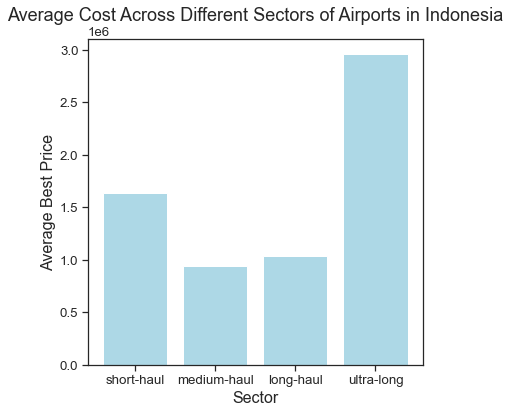

In [153]:
# Set the style and size of the plot
sns.set(style='ticks', font_scale=1.2)

# Create the plot with the desired figsize
fig, ax = plt.subplots(figsize=(6, 6))
mean_price_dist_buck

# Add data to the plot
barchart = plt.bar(mean_price_dist_buck['sectors'], mean_price_dist_buck['best_price'], color='lightblue', label="weekday")
ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Average Best Price', fontsize=16)
ax.set_title('Average Cost Across Different Sectors of Airports in Indonesia', fontsize=18)


The ultra-long-haul flights have the highest average best price, which is likely due to the longer distance traveled. For short-haul flights, the limited number of available flights may be contributing to the higher prices, as demand for the limited number of seats drives up prices. The deep-dive into the routes has been performed in section 4.

## Average number of flights by calendar day (of departure)


In this step, a subset of columns consisting of depart_date, airport_to, and calendar_day was taken. This was followed by taking the unique values of the dataframe to remove any duplicated columns resulting from different extraction times of best price for the origin and destination combinations.

In [163]:
avg_cal_day=ticket_price_dist[['calendar_day','airport_to','depart_date','calendar_year','calendar_month']]  

In [164]:
avg_cal_day=avg_cal_day.drop_duplicates()

In [178]:
avg_cal_day.loc[avg_cal_day['airport_to']=='BDJ'].head(2)

,calendar_day,airport_to,depart_date,calendar_year,calendar_month
29898,24,BDJ,2023-04-24,2023,4
29899,17,BDJ,2023-04-17,2023,4


In [159]:
avg_cal_day_df_1=avg_cal_day.groupby(['calendar_day','calendar_month'])['airport_to'].count()
avg_cal_day_df_1=avg_cal_day_df_1.reset_index()
avg_cal_day_df_1.head()
avg_cal_day_df_1=avg_cal_day_df_1.groupby(['calendar_day'])['airport_to'].mean()
avg_cal_day_df_1=avg_cal_day_df_1.reset_index()

In [160]:
avg_cal_day_df_1.head(2)

,calendar_day,airport_to
0,1,28.857143
1,2,29.000000


Text(0.5, 1.0, 'Average Number of Flights by Calendar Days')

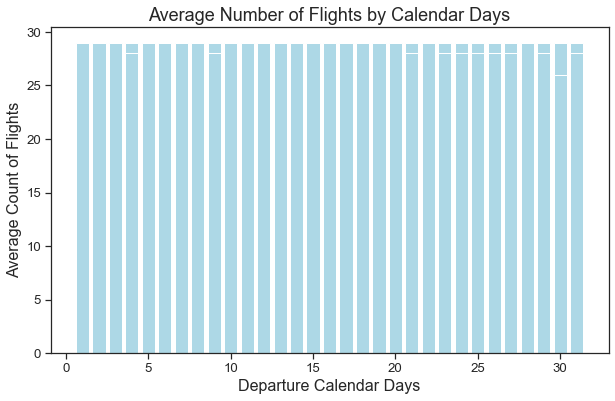

In [172]:
# Set the style and size of the plot
sns.set(style='ticks', font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 6))
mean_price_dist_buck

# Add data to the barplot
barchart = plt.bar(avg_cal_day_df_1['calendar_day'], avg_cal_day_df_1['airport_to'], color='lightblue', label="calendar_day")
ax.set_xlabel('Departure Calendar Days', fontsize=16)
ax.set_ylabel('Average Count of Flights', fontsize=16)
ax.set_title('Average Number of Flights by Calendar Days', fontsize=18)


The bar plot displays the average number of flights by calendar days. Observing the plot, it can be inferred that there is little variation in the number of average flights departing on any given calendar day, with an average count of flights ranging from 28 to 30.

## Additional analysis and LASSO model for predicting best price

A subset of the dataframe is taken to filter the required columns and is referred to as "model_data" in further analysis.

In [560]:
ticket_price_dist.columns

Index(['extract_timestamp', 'origin', 'destination', 'depart_date',
       'best_price', 'airport_from', 'airport_to', 'distance_km',
       'flight_time_hour', 'extract_date', 'time', 'weekday_name',
       'calendar_day', 'calendar_year', 'calendar_month', 'week_number',
       'extraction_period', 'sectors', 'key'],
      dtype='object')

In [561]:
model_data=ticket_price_dist #.loc[ticket_price_dist['destination']=='BDO']
model_data=model_data[['calendar_year','calendar_day','calendar_month','best_price',\
                       'flight_time_hour','destination','extraction_period','sectors','distance_km']]
model_data=model_data.reset_index()

In [231]:
model_data.shape

(45395, 9)

model_data= model_data.groupby(['calendar_year','calendar_day','calendar_month','destination','extraction_period','sectors'])\
.agg({'best_price':'mean','flight_time_hour':'mean'})


In [290]:
model_data.groupby(['sectors'])['destination'].nunique()

sectors
short-haul      2
medium-haul    13
long-haul       7
ultra-long      7
Name: destination, dtype: int64

### Creating boxplots to examine the spread in ticket prices for each destination

In sns.boxplot, whiskers indicate the range of data points beyond the upper (Q3) and lower quartiles (Q1) of the box.The whiskers extend to the furthest data point that lies within 1.5 times the interquartile range (IQR) from the upper or lower quartile. Data points that fall outside this range are considered outliers.

The objective is to visualize the distribution of a dataset and examine the differences in the center, spread, and skewness of the data between different destinations.

Assumption for the boxplot: data has a unimodal distribution and approximately symmentrical

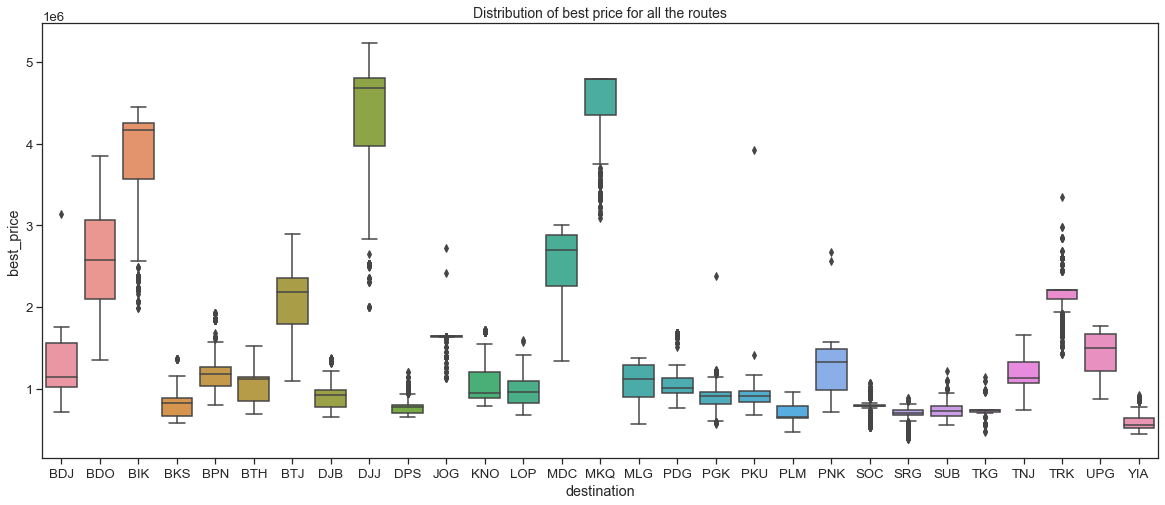

In [374]:
fig, ((ax1)) = plt.subplots(nrows=1 ,ncols=1, figsize=(20, 8)) #, (ax2)

# Create the first boxplot
sns.boxplot(y = "best_price", x = "destination", \
            data = model_data.sort_values("destination", ascending = True), ax=ax1)
ax1.set_title('Distribution of best price for all the routes', fontsize=14)


# Show the plot
plt.show()

It is worth noting that the median price of JKTC-BDO is higher than the median prices of most flight routes irrespective of the distance range, and exhibits a variability that is close to a bell curve.

__Boxplot to compare the distribution of price of short and medium haul destinations__

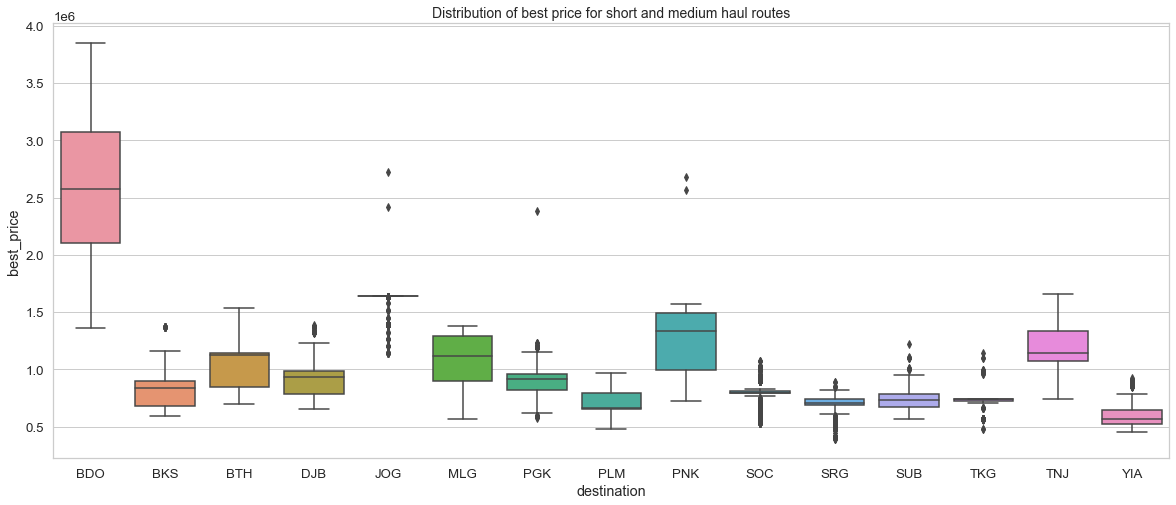

In [331]:
fig, ((ax1)) = plt.subplots(nrows=1 ,ncols=1, figsize=(20, 8)) #, (ax2)

# Create the first boxplot
sns.boxplot(y = "best_price", x = "destination", data = model_data.loc[model_data['sectors'].isin(['short-haul','medium-haul'])].sort_values("destination", ascending = True), ax=ax1)
ax1.set_title('Distribution of best price for short and medium haul routes', fontsize=14)

# Create the second boxplot
#sns.boxplot(y = "best_price", x = "destination", data = model_data.loc[model_data['sectors']=='medium-haul'].sort_values("destination", ascending = True), ax=ax2)
#ax2.set_title('Distribution of best price for medium-haul routes', fontsize=14)



# Show the plot
plt.show()

__Histogram to compare the distribution of price of BDO and TKG destination__

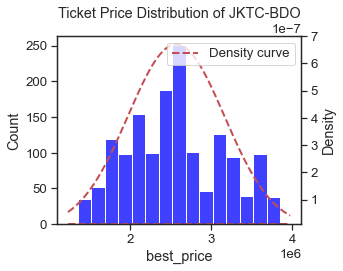

In [386]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot the histogram
sns.histplot(model_data.loc[model_data['destination']=='BDO'].best_price, ax=ax, color='blue')
ax.set_title('Ticket Price Distribution of JKTC-BDO')
ax.set_xlabel('best_price')
ax.set_ylabel('Count')

# Calculate the mean and standard deviation of the data
mu, std = norm.fit(model_data.loc[model_data['destination']=='BDO'].best_price)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 200)
y = norm.pdf(x, mu, std)
ax.plot(x, y, 'r--', linewidth=2)
# Adding a secondary y-axis for the bell curve
ax2 = ax.twinx()
ax2.set_ylabel('Density')
ax2.plot(x, y, 'r--', linewidth=2, label='Density curve')

ax2.legend(loc='upper right')

fig.tight_layout()

plt.show()


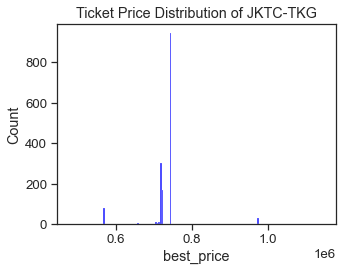

In [369]:
fig, ax = plt.subplots(figsize=(5, 4))


sns.histplot(model_data.loc[model_data['destination']=='TKG'].best_price, ax=ax, color='blue')
ax.set_title('Ticket Price Distribution of JKTC-TKG')
ax.set_xlabel('best_price')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In the case of short-haul flights, the spread of the ticket prices for the destination TKG forms a short box, indicating that the prices hover around the median. In contrast, BDO exhibits more variability in price. This is despite the fact that the distances covered for both destinations are not different, with values of 133 km and 191 km. This indicates that with respect to the route of JKTC to TKG there is a balance in the supply of air service and demand from travellers.

 

In [314]:
##Counting the number of depart_dates against the destination
avg_cal_day_df_2=ticket_price_dist.groupby(['airport_to'])['depart_date'].nunique()
avg_cal_day_df_2=avg_cal_day_df_2.reset_index()
avg_cal_day_df_2.head()
avg_cal_day_df_2[avg_cal_day_df_2['airport_to'].isin(['BDO','TKG'])]

,airport_to,depart_date
1,BDO,208
24,TKG,212


Similarly, for medium-haul destinations such as SOC, JOG, SUB, and SRG, the variability in prices is low, with prices mostly centered around the median when compared to other destinations. These destinations are labeled as group 1, while the rest of the destinations in the medium-haul category are labeled as group 2.

Taking the count of depart dates by destinations to check whether the availability of the flights are causing the difference.

In [322]:

print("Count of unique depart_date for group-1:",avg_cal_day_df_2[avg_cal_day_df_2['airport_to'].isin([ 'MLG', 'YIA',  'BTH', 'BKS', 'DJB', 'PLM', 'PGK', 'TNJ', 'PNK'])].depart_date.unique())
print("Count of unique depart_date for group-2:",avg_cal_day_df_2[avg_cal_day_df_2['airport_to'].isin([  'SRG', 'SUB', 'JOG', 'SOC'])].depart_date.unique())

Count of unique depart_date for group-1: [212]
Count of unique depart_date for group-2: [212]


As previously observed in short-haul case, in some areas the forces of supply and demand appear to be evenly balanced, while in others, one might have more influence than the other.

__Boxplot to compare the distribution of price of long and Ultra-long destinations__

Text(0.5, 1.0, 'Distribution of best price for ultra-long routes')

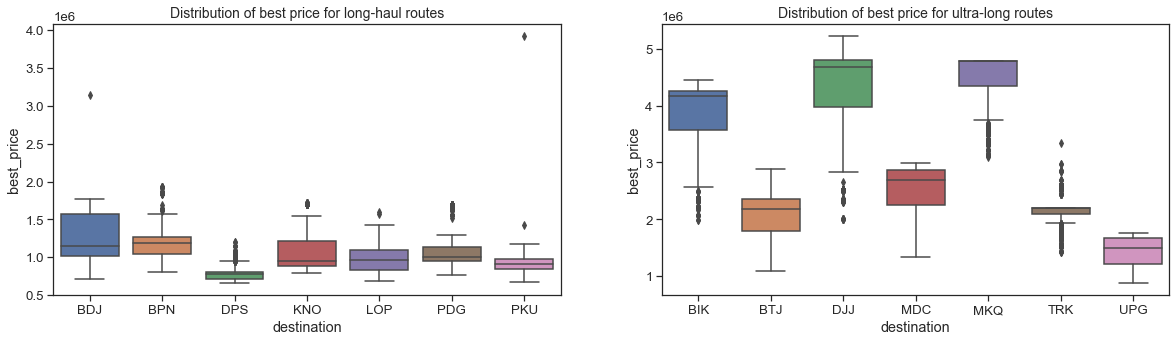

In [370]:

# Create the third boxplot
fig, ((ax3), (ax4)) = plt.subplots(nrows=1 ,ncols=2, figsize=(20, 5))
sns.boxplot(y = "best_price", x = "destination", data = model_data.loc[model_data['sectors']=='long-haul'].sort_values("destination", ascending = True), ax=ax3)
ax3.set_title('Distribution of best price for long-haul routes', fontsize=14)

# Create the fourth boxplot
sns.boxplot(y = "best_price", x = "destination", data = model_data.loc[model_data['sectors']=='ultra-long'].sort_values("destination", ascending = True), ax=ax4)
ax4.set_title('Distribution of best price for ultra-long routes', fontsize=14)

The median values for long-haul routes appear to have less variability compared to other distance ranges. However, ultra-long haul routes seem to have more variability.

Kurtosis is a statistical measure that describes the shape of a distribution of a dataset. It measures the degree of the outliers in relation to the normal distribution. High kurtosis indicates that a dataset has more outliers than a normal distribution. Conversely, low kurtosis indicates a lack of outliers in comparison to a normal distribution. The extreme case of low kurtosis is a uniform distribution

In [388]:
kurtosis_by_dest = pd.DataFrame(model_data.loc[model_data['sectors']=='ultra-long'].groupby('destination')['best_price'].apply(kurtosis))

# Sorting the results in descending order by kurtosis value
kurtosis_by_dest = kurtosis_by_dest.sort_values('best_price', ascending=False)

print(kurtosis_by_dest)

             best_price
destination            
TRK            2.436421
MKQ            1.334527
DJJ            0.953687
BIK            0.611218
MDC           -0.152768
BTJ           -0.456872
UPG           -1.167840


The kurtosis values suggest that TRK and MKQ have volatile ticket prices with fatter tails, indicating that more prices are near the mean. Whereas, UPG has a flattened peak with lighter tails compared to a normal distribution, suggesting that there are less outliers.

### Analysing the  relationship of extract period and  price change

This step analyzes two destinations from the ultra-long sectors for two extreme cases from Kurtosis step TRK with Kurtosis value 2.44 and UPG with Kurtosis value of -1.167. 

In [469]:
TRK_df= ticket_price_dist.loc[ticket_price_dist['airport_to']=='TRK']
TRK_df=TRK_df.sort_values(by=['depart_date', 'extract_date'], ascending=[True, True]).drop_duplicates()


In [470]:
grouped= TRK_df.groupby(['depart_date'])['extract_timestamp'].count()
grouped = grouped.reset_index().rename(columns={'index': 'date'})
grouped.sort_values(by=['extract_timestamp'], ascending=[False]).head(4)

,depart_date,extract_timestamp
104,2023-04-15,14
106,2023-04-17,14
99,2023-04-10,14
100,2023-04-11,14


 Plotting the number of days left before the actual departure vs best price extracted

Text(0.5, 1.0, 'Scatter plot of best price vs number of days ahead of departure for 30 March,2023')

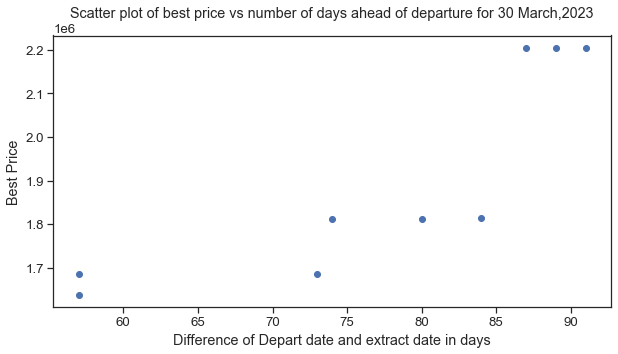

In [496]:
fig, ((ax3)) = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

## Selecting a date closer to the festival celebrated on 22 April

ax3.scatter(TRK_df.loc[TRK_df['depart_date']=='2023-03-30']['extraction_period'].dt.days, \
            TRK_df.loc[TRK_df['depart_date']=='2023-03-30']['best_price'])
ax3.set_xlabel('Difference of Depart date and extract date in days')
ax3.set_ylabel('Best Price')
ax3.set_title('Scatter plot of best price vs number of days ahead of departure for 30 March,2023')


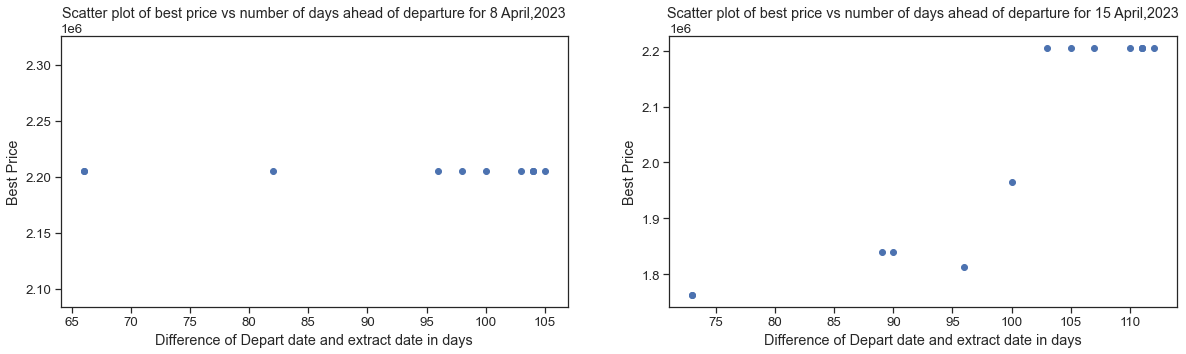

In [498]:
fig, ((ax3), (ax4)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

## Selecting a date closer to the festival celebrated on 22 April

ax3.scatter(TRK_df.loc[TRK_df['depart_date']=='2023-04-08']['extraction_period'].dt.days, \
            TRK_df.loc[TRK_df['depart_date']=='2023-04-08']['best_price'])
ax3.set_xlabel('Difference of Depart date and extract date in days')
ax3.set_ylabel('Best Price')
ax3.set_title('Scatter plot of best price vs number of days ahead of departure for 8 April,2023')


## Selecting a date a little farther from the festival day
ax4.scatter(TRK_df.loc[TRK_df['depart_date']=='2023-04-15']['extraction_period'].dt.days,
            TRK_df.loc[TRK_df['depart_date']=='2023-04-15']['best_price'])
ax4.set_xlabel('Difference of Depart date and extract date in days')
ax4.set_ylabel('Best Price')
ax4.set_title('Scatter plot of best price vs number of days ahead of departure for 15 April,2023')

plt.show()


By comparing the scatter plots for TRK from two different departure dates that are weeks apart, it can be observed that the behavior is not different on the week of 30 March, 3 weeks ahead of the Eid or 15 April, 1 week ahead of the celebration. However, the prices seem to be decreasing as the departure date nears. This could be attributed to the fact that airlines may lower their prices to attract more travelers who are willing to book at a lower cost. The ticket prices do not seem to be going up as the extracted days come closer to the departure date.

In [504]:
UPG_df= ticket_price_dist.loc[ticket_price_dist['airport_to']=='UPG']
UPG_df=UPG_df.sort_values(by=['depart_date', 'extract_date'], ascending=[True, True]).drop_duplicates()

##Converting the time delta column t seconds and then back to number of days
UPG_df['extraction_period_1']=UPG_df['extraction_period'].dt.total_seconds().astype('float64')/86400

In [505]:
grouped= UPG_df.groupby(['depart_date'])['extract_timestamp'].count()
grouped = grouped.reset_index().rename(columns={'index': 'date'})
grouped.sort_values(by=['extract_timestamp'], ascending=[False]).head(4)

,depart_date,extract_timestamp
97,2023-04-08,14
90,2023-04-01,14
92,2023-04-03,14
93,2023-04-04,14


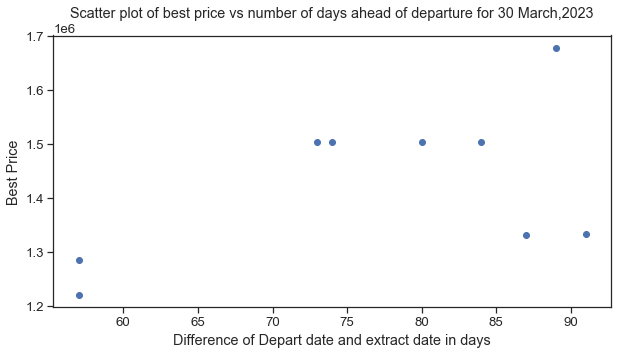

In [509]:

## Selecting a date a little farther from the festival day
fig, ((ax4)) = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax4.scatter(UPG_df.loc[UPG_df['depart_date']=='2023-03-30']['extraction_period'].dt.days, \
            UPG_df.loc[UPG_df['depart_date']=='2023-03-30']['best_price'])
ax4.set_xlabel('Difference of Depart date and extract date in days')
ax4.set_ylabel('Best Price')
ax4.set_title('Scatter plot of best price vs number of days ahead of departure for 30 March,2023')

plt.show()


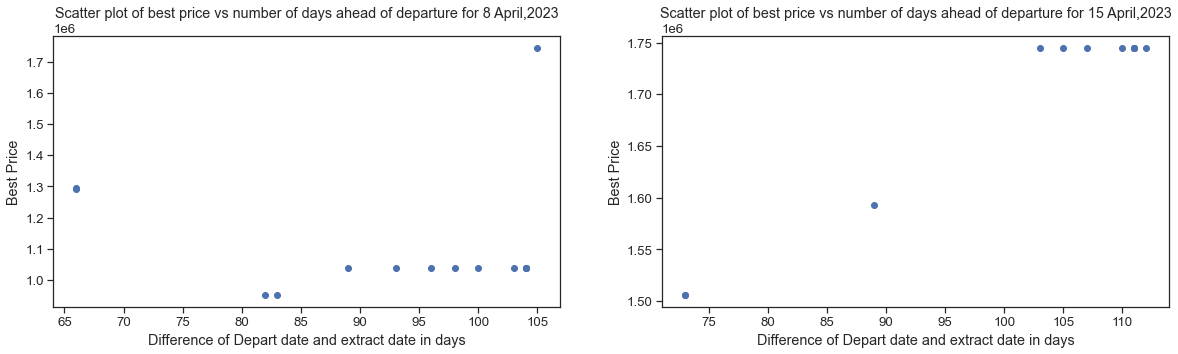

In [510]:
fig, ((ax3), (ax4)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

## Selecting a date closer to the festival celebrated on 22 April

ax3.scatter(UPG_df.loc[UPG_df['depart_date']=='2023-04-8']['extraction_period'].dt.days,\
            UPG_df.loc[UPG_df['depart_date']=='2023-04-8']['best_price'])
ax3.set_xlabel('Difference of Depart date and extract date in days')
ax3.set_ylabel('Best Price')
ax3.set_title('Scatter plot of best price vs number of days ahead of departure for 8 April,2023')

ax4.scatter(UPG_df.loc[UPG_df['depart_date']=='2023-04-15']['extraction_period'].dt.days, \
            UPG_df.loc[UPG_df['depart_date']=='2023-04-15']['best_price'])
ax4.set_xlabel('Difference of Depart date and extract date in days')
ax4.set_ylabel('Best Price')
ax4.set_title('Scatter plot of best price vs number of days ahead of departure for 15 April,2023')
 
plt.show()

Now making the same comparison for UPG with respect to two different departure dates that are weeks apart. It is observed that for the 30th of March departure and 8th of April (2 weeks ahead of the festival), the price behavior is different. The prices for the latter seem to be going upon drawing closer to the depart date, which could indicate that seat availability may be constrained.

### LASSO Model for Best price prediction

The dependent variable in this study is the best price of a flight ticket, which is influenced by various features such as distance, extraction period, calendar, year, and month. To predict the ticket price, a LASSO cross-validation-based regression model is utilized.

The column 'extraction_period' is defined as the difference between the depart date and date time during extraction.Through one-hot encoding, the destinations are converted into dummy variables. That is, each categorical value is represented by a new binary column.

In [567]:
model_data.columns

Index(['index', 'calendar_year', 'calendar_day', 'calendar_month',
       'best_price', 'flight_time_hour', 'destination', 'extraction_period',
       'sectors', 'distance_km'],
      dtype='object')

In [570]:
Destination = model_data[["destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head(2)

,destination_BDO,destination_BIK,destination_BKS,destination_BPN,destination_BTH,destination_BTJ,destination_DJB,destination_DJJ,destination_DPS,destination_JOG,...,destination_PLM,destination_PNK,destination_SOC,destination_SRG,destination_SUB,destination_TKG,destination_TNJ,destination_TRK,destination_UPG,destination_YIA
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [579]:
## Concatenating the summy variables to the model dataset
data_train=model_data
data_train['extraction_period']=data_train['extraction_period'].dt.days

Dropping the columns that carry no useful or redundant information

In [580]:
data_train.drop(["destination","sectors",'calendar_year','index'],axis=1,inplace=True)
data_train.head(2)

,calendar_day,calendar_month,best_price,flight_time_hour,extraction_period,distance_km
0,25,4,2310582.0,2.65,122,1797.98
1,4,4,2310582.0,2.65,101,1797.98


Correlation matrix is used to identify the linear relationships between variables and to make predictions based on those relationships.

<AxesSubplot: >

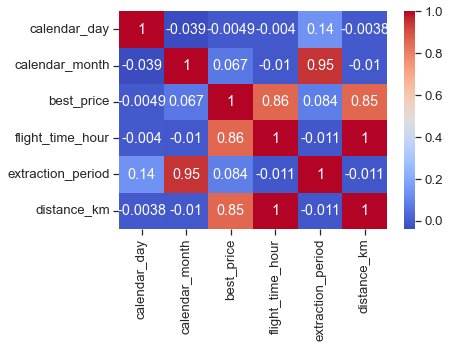

In [582]:
corr_matrix = data_train.corr()

# Print correlation matrix

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

It can be observed from the correlogram that flight_time and distance are highly correlated. Hence, one of them has to be dropped. Additionally, the calendar month is exhibiting high correlation with the extraction period and will also be dropped. On the other hand, in the rest of the cases, the relationship is not linear because the values are close to zero.
A linear model may not fit well here because of the non linear relationship between the features and the target variable.

In [650]:
data_train.drop(["distance_km",'calendar_month'],axis=1,inplace=True)

In [651]:
data_train=pd.concat([data_train, Destination],axis=1)

In [652]:
data_train.columns

Index(['calendar_day', 'best_price', 'flight_time_hour', 'extraction_period',
       'destination_BDO', 'destination_BIK', 'destination_BKS',
       'destination_BPN', 'destination_BTH', 'destination_BTJ',
       'destination_DJB', 'destination_DJJ', 'destination_DPS',
       'destination_JOG', 'destination_KNO', 'destination_LOP',
       'destination_MDC', 'destination_MKQ', 'destination_MLG',
       'destination_PDG', 'destination_PGK', 'destination_PKU',
       'destination_PLM', 'destination_PNK', 'destination_SOC',
       'destination_SRG', 'destination_SUB', 'destination_TKG',
       'destination_TNJ', 'destination_TRK', 'destination_UPG',
       'destination_YIA', 'destination_BDO', 'destination_BIK',
       'destination_BKS', 'destination_BPN', 'destination_BTH',
       'destination_BTJ', 'destination_DJB', 'destination_DJJ',
       'destination_DPS', 'destination_JOG', 'destination_KNO',
       'destination_LOP', 'destination_MDC', 'destination_MKQ',
       'destination_MLG', 

In [653]:
##Creating dependent and  independent variables
X= data_train.loc[:,data_train.columns!='best_price']
y=data_train['best_price']

In [654]:
##Splitting the dataset for training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

StandardScaler scales the data by subtracting the mean from each feature and then dividing it by the standard deviation. This makes the mean of the feature 0 and the variance 1. The motivation behind scaling is to make sure that each feature contributes equally to the analysis and the model is not influenced by one feature due to the units difference.

In [655]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)

X_val_scaled=scaler.fit_transform(X_val.values)


LassoCV() is a class in python that aids in implementing linear model with L1 regularisation. It selects the regulariser value(alpha) based on cross-validation and R-sqaured metric.The penalty used by LassoCV shrinks the coefficients of some explanatory features to zero, effectively removing them from the model. The variables with non-zero coefficients after regularisation are the selected ones based on the criteria.

In [656]:
lasso_cv = LassoCV(cv=20, random_state=42,max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# Print optimal value of penalty parameter
print('Optimal alpha:', lasso_cv.alpha_)


Optimal alpha: 931.0953998437425


In [662]:
X_train_scaled.shape ## There are 59

(36316, 59)

In [692]:
##Building the model with recommended alpha value
lasso = Lasso(alpha=lasso_cv.alpha_, random_state=42,max_iter=10000)
lasso.fit(X_train_scaled, y_train)
coef = pd.Series(lasso.coef_,)
print('Number of variables:', sum(coef != 0))
print("Feature and the coeffecient value")


coef_df = pd.DataFrame(list(zip(lasso.coef_, X)), columns=['Coefficient', 'Feature'])
print(coef_df.head(5))
#print(selected_features)
#print(coef[coef != 0])


Number of variables: 51
Feature and the coeffecient value
     Coefficient            Feature
0  -14457.048093       calendar_day
1  810653.630241   flight_time_hour
2  105400.136626  extraction_period
3  348360.741595    destination_BDO
4  122067.557601    destination_BIK


In [696]:
coef_df['Coefficient_Ceiling_1'] = coef_df['Coefficient'].apply(lambda x: math.ceil(x))

In [697]:
##Features which are removed from the model as they don't improve model performance
coef_df.loc[coef_df['Coefficient_Ceiling_1']==0].Feature.unique()

array(['destination_BKS', 'destination_BTH', 'destination_SOC',
       'destination_BPN', 'destination_DPS', 'destination_KNO',
       'destination_LOP'], dtype=object)

Seven features that belong to the medium-haul and long-haul sectors have been removed from the dataset. The medium and long haul segments show less variability in ticket prices when compared between destinations within each segment. This could be the reason why these variables might not be adding much value to the Lasso model because other destinations might carry similar information.

In [693]:
ticket_price_dist.loc[ticket_price_dist['airport_to'].isin(['BTH','BKS','SOC','BPN','DPS','KNO','LOP'])].key.unique()

array(['medium-haulSOC', 'medium-haulBTH', 'medium-haulBKS',
       'long-haulKNO', 'long-haulBPN', 'long-haulDPS', 'long-haulLOP'],
      dtype=object)

In [698]:
# Assess model performance
y_pred = lasso_cv.predict(X_val_scaled)

print('R squared training set', round(lasso.score(X_train_scaled, y_train)*100, 2))
print('R squared test set', round(lasso.score(X_val_scaled, y_val)*100, 2))
print('Mean squared error:', mean_squared_error(y_val, y_pred))
print('Mean absolute percentage error:', np.mean( np.abs((y_val - y_pred) / y_val))*100)


R squared training set 94.18
R squared test set 94.07
Mean squared error: 70347060980.21106
Mean absolute percentage error: 13.468745520685996


In [702]:
coef_df.sort_values(by='Coefficient_Ceiling_1',ascending=False).head(3)


,Coefficient,Feature,Coefficient_Ceiling_1
1,810653.630241,flight_time_hour,810654
3,348360.741595,destination_BDO,348361
16,153501.819747,destination_MKQ,153502


The model assessment reveals that the R-squared value is consistent for both the training and test datasets, which indicates that the model has good variability explanation. Furthermore, the MAPE value on the test dataset is 13%, which indicates a reasonable performance in predicting the best price.

The features flight_time_hour , destinations BDO and MKQ  seem to be influencing the best price the most in comparison to other ones.